<a href="https://colab.research.google.com/github/rhearjethvani/MITFutureMakers/blob/main/sarcasmDetection/sarcasmDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [49]:
import pandas as pd
import seaborn as sns
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.models import Model
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [40]:
df = pd.read_json("/content/gdrive/MyDrive/Colab Notebooks/Sarcasm_Headlines_Dataset.json", lines=True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [41]:
del df['article_link']
df.head()

,headline,is_sarcastic
0,former versace store clerk sues over secret 'b...,0
1,the 'roseanne' revival catches up to our thorn...,0
2,mom starting to fear son's web series closest ...,1
3,"boehner just wants wife to listen, not come up...",1
4,j.k. rowling wishes snape happy birthday in th...,0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


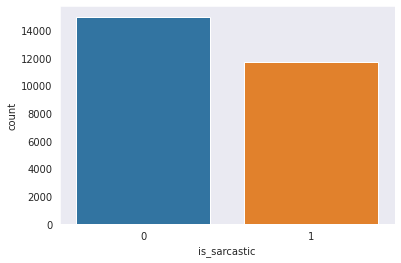

In [42]:
sns.set_style("dark")
sns.countplot(df.is_sarcastic)

In [50]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [51]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

df['headline']=df['headline'].apply(denoise_text)

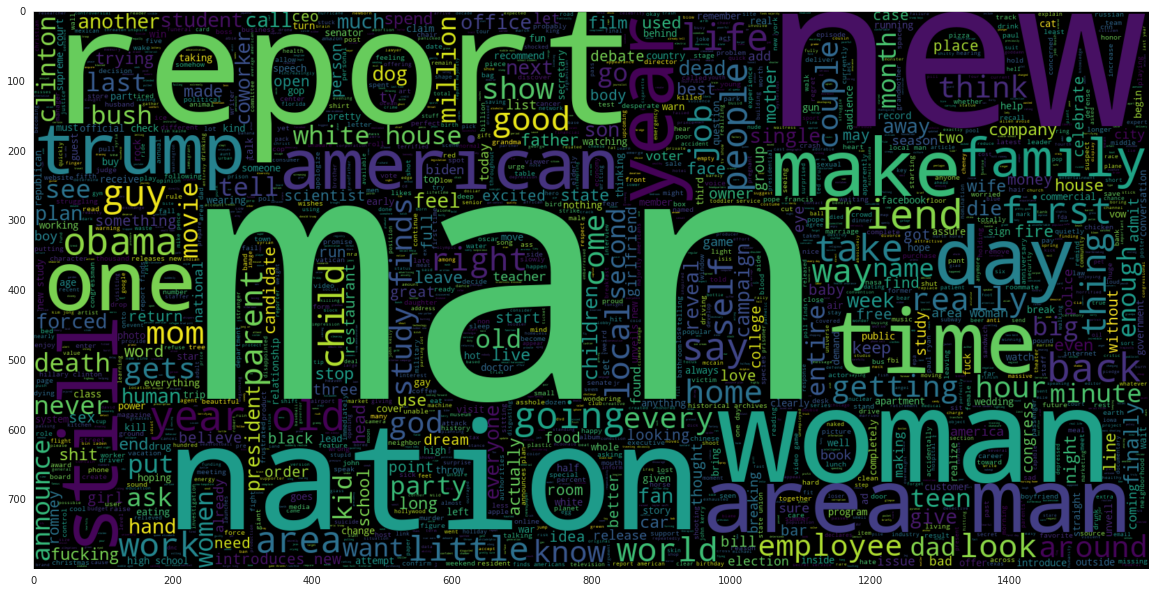

In [54]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc, interpolation = 'bilinear')

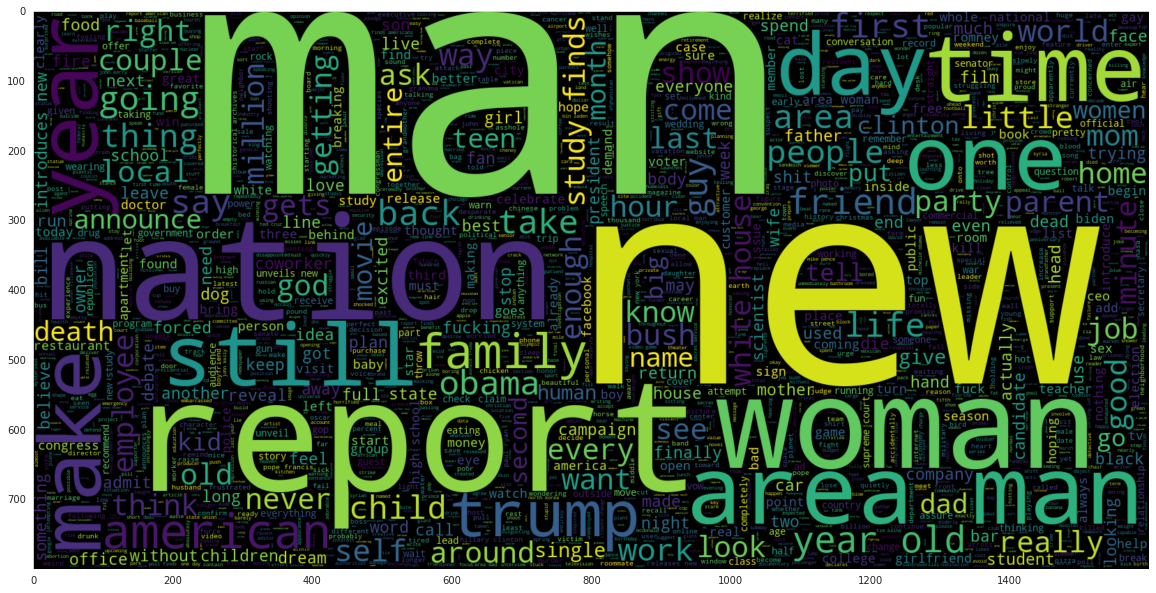

In [55]:
plt.figure(figsize = (20,20))
wc = WordCloud(max_words = 2000, width = 1600, height = 800).generate(" ".join(df[df.is_sarcastic == 1].headline))
plt.imshow(wc, interpolation = 'bilinear')

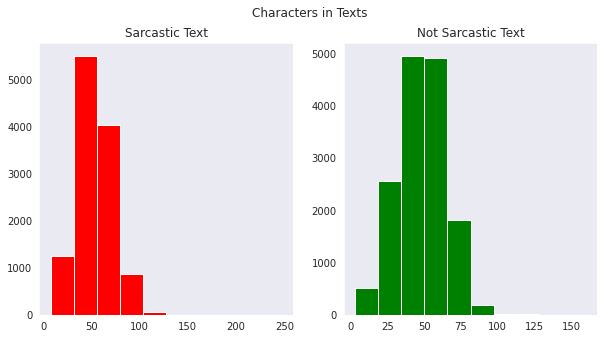

In [56]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.len()
ax1.hist(text_len, color='red')
ax1.set_title('Sarcastic Text')
text_len=df[df['is_sarcastic']==0]['headline'].str.len()
ax2.hist(text_len, color='green')
ax2.set_title('Not Sarcastic Text')
fig.suptitle('Characters in Texts')
plt.show()

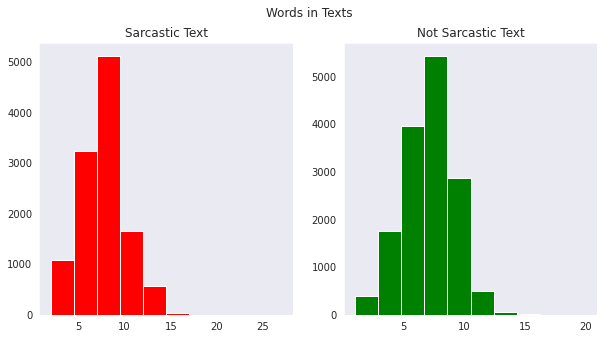

In [57]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
text_len=df[df['is_sarcastic']==1]['headline'].str.split().map(lambda x:len(x))
ax1.hist(text_len,color='red')
ax1.set_title('Sarcastic Text')
text_len=df[df['is_sarcastic']==0]['headline'].str.split().map(lambda x: len(x))
ax2.hist(text_len,color='green')
ax2.set_title('Not Sarcastic Text')
fig.suptitle('Words in Texts')
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0.98, 'Average Word Length in Each Text')

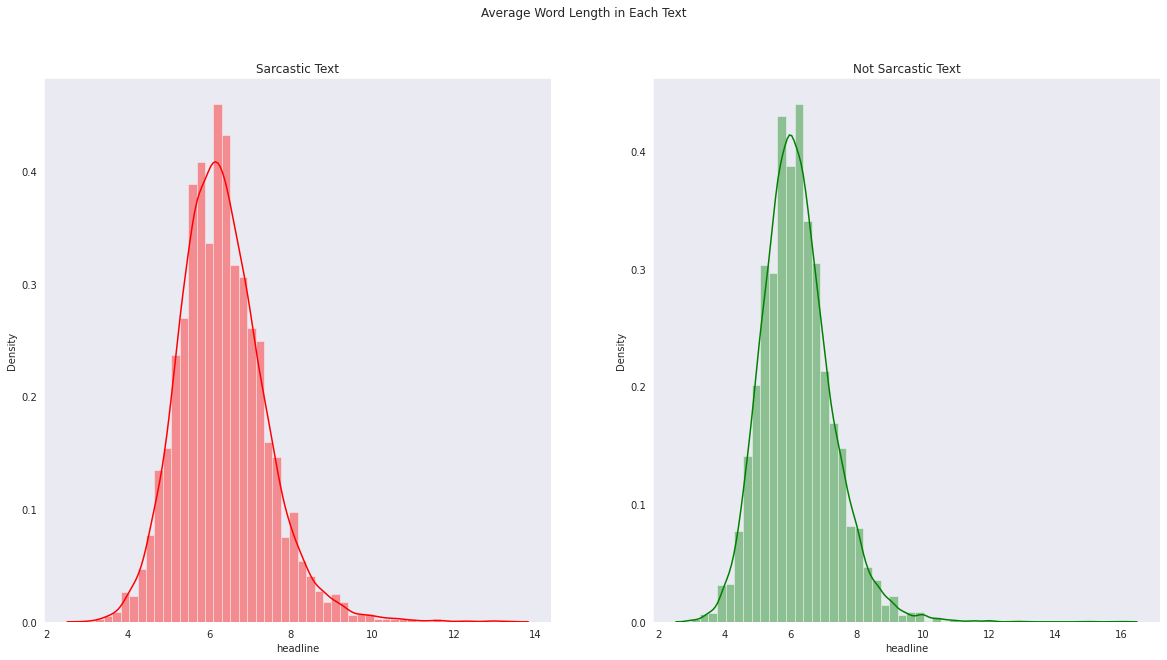

In [58]:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,10))
word=df[df['is_sarcastic']==1]['headline'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax1, color='red')
ax1.set_title('Sarcastic Text')
word=df[df['is_sarcastic']==0]['headline'].str.split().apply(lambda x: [len(i) for i in x])
sns.distplot(word.map(lambda x: np.mean(x)), ax=ax2, color='green')
ax2.set_title('Not Sarcastic Text')
fig.suptitle('Average Word Length in Each Text')

In [59]:
df.is_sarcastic.value_counts()

0    14985
1    11724
Name: is_sarcastic, dtype: int64

In [60]:
len(df.is_sarcastic)

26709

In [61]:
X = df.iloc[:,0]
Y = df.iloc[:,1]

In [62]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
len(X_test)

5342

In [63]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)
sequences_matrix.shape

(21367, 150)

In [64]:
sequences_matrix

array([[  0,   0,   0, ...,   0,   0,   0],
       [  0,   0,   0, ...,   0, 228, 188],
       [  0,   0,   0, ..., 195,  34, 146],
       ...,
       [  0,   0,   0, ...,   1, 371, 839],
       [  0,   0,   0, ..., 444, 133, 802],
       [  0,   0,   0, ...,   9, 818,  67]], dtype=int32)

In [65]:
np.amax(sequences_matrix)

999

In [76]:
def RNN():
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(max_words, 50, input_length=max_len)(inputs)
    layer = LSTM(128)(layer)
    layer = Dense(256, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.2)(layer)
    layer = Dense(1, name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

In [77]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               91648     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               33024     
_________________________________________________________________
activation_4 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [79]:
history = model.fit(sequences_matrix, Y_train, batch_size=100, epochs=5, validation_split=0.1)

Epoch 1/5
193/193 [==============================] - 4s 20ms/step - loss: 0.4863 - accuracy: 0.7613 - val_loss: 0.5323 - val_accuracy: 0.7361
Epoch 2/5
193/193 [==============================] - 4s 20ms/step - loss: 0.4462 - accuracy: 0.7803 - val_loss: 0.5165 - val_accuracy: 0.7356
Epoch 3/5
193/193 [==============================] - 4s 19ms/step - loss: 0.4391 - accuracy: 0.7843 - val_loss: 0.5562 - val_accuracy: 0.7398
Epoch 4/5
193/193 [==============================] - 4s 19ms/step - loss: 0.4377 - accuracy: 0.7882 - val_loss: 0.5267 - val_accuracy: 0.7408
Epoch 5/5
193/193 [==============================] - 4s 19ms/step - loss: 0.4286 - accuracy: 0.7911 - val_loss: 0.5327 - val_accuracy: 0.7445


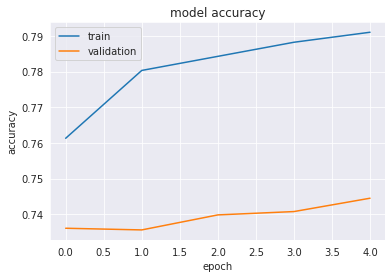

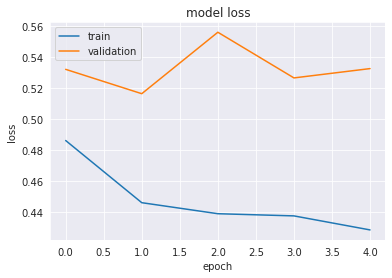

In [80]:
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.grid()
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

fig = plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.grid()
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [81]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences, maxlen=max_len)
test_sequences_matrix.shape

(5342, 150)

In [82]:
accr = model.evaluate(test_sequences_matrix, Y_test)
print('Test set\n Loss: {:0.3f}\n Accuracy: {:0.3f}'.format(accr[0], accr[1]))

167/167 [==============================] - 1s 7ms/step - loss: 0.5120 - accuracy: 0.7527
Test set
 Loss: 0.512
 Accuracy: 0.753
